# 4.6 Pitch Attidute and Altitude Hold Autopilots

#### Examples 4.6-1 through 4.6-3

In [1]:
import sys
sys.path.append('../')
from lin_transport import get_lin_transport
import control as ct
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
RTOD = 57.296
# Constants
Vt = 500  # ft/s
alpha = 2.0/RTOD  # rad
theta = 2.0/RTOD  # rad
altitude = 25e3  # ft
x_Earth = 0  # ft
X0 = [Vt, alpha, theta, 0, altitude, x_Earth]
thtl = 0.2  # throttle 0-1
elev = -2.0  # deg
U0 = [thtl, elev]

sys = get_lin_transport(X0, U0, theta - alpha)

[ 0.0725267   0.20438501 -2.38215508]
Trim results:
Cost = 1.0962256112451988e-11
Keas (knots): 198.86
Alpha (deg): 4.16
Theta (deg): 4.16
Throttle (0-1): 0.20
Elevator (deg): -2.38


In [3]:
ap = sys.A[0:5,0:5]
bp = sys.B[0:5,[1]]
cp = sys.C[0:5,0:5][[2,3]]
dp = sys.D[[2,3]][:,[1]]
plant = ct.ss(ap, bp, cp, dp)
plant

StateSpace(
array([[-8.23544715e-03,  1.89374271e+01, -3.21697180e+01,
         0.00000000e+00,  5.90523872e-05],
       [-2.57455872e-04, -5.67612118e-01,  0.00000000e+00,
         1.00000000e+00,  2.26441492e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00],
       [ 1.31145653e-05, -1.48473397e+00,  0.00000000e+00,
        -4.75990108e-01, -1.51283776e-07],
       [ 0.00000000e+00, -4.99995617e+02,  4.99995617e+02,
         0.00000000e+00,  0.00000000e+00]]),
array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.01978141],
       [ 0.        ]]),
array([[ 0.   ,  0.   , 57.296,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , 57.296,  0.   ]]),
array([[0.],
       [0.]]),
states=5, outputs=2, inputs=1)

In [4]:
sysa = ct.ss([-10], [10], [-1], [0]) # actuator (change sign for elev up positive)
sys1 = ct.series(sysa, plant)
sys1_tf = ct.ss2tf(ct.ss(sys1.A, sys1.B, sys1.C[[0]], sys1.D[[0]]))

zeros = ct.zeros(sys1_tf)
poles = ct.poles(sys1_tf)

print("Closed Loop Zeros:", zeros)
print("Closed Loop Poles:", poles)

Closed Loop Zeros: [ 3.79237827e-02+39938857.7660074j  3.79237827e-02-39938857.7660074j
 -1.62676979e-04       +0.j        -1.90216221e-02       +0.j
 -5.56663266e-01       +0.j       ]
Closed Loop Poles: [-1.00000000e+01+0.j         -5.23360199e-01+1.21742819j
 -5.23360199e-01-1.21742819j -2.46640595e-03+0.09007424j
 -2.46640595e-03-0.09007424j -1.84462701e-04+0.j        ]


c:\git\StevensAndLewis\SaL\Lib\site-packages\scipy\signal\_filter_design.py:1230: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


C:\Users\jehen\AppData\Local\Temp\ipykernel_19008\798323782.py:2: FutureWarning: keyword 'kvect' is deprecated; use 'gains'
  ct.root_locus(sys1_tf,kvect=np.linspace(0,5,500), xlim=[-2, 1], ylim=[-3, 3])
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


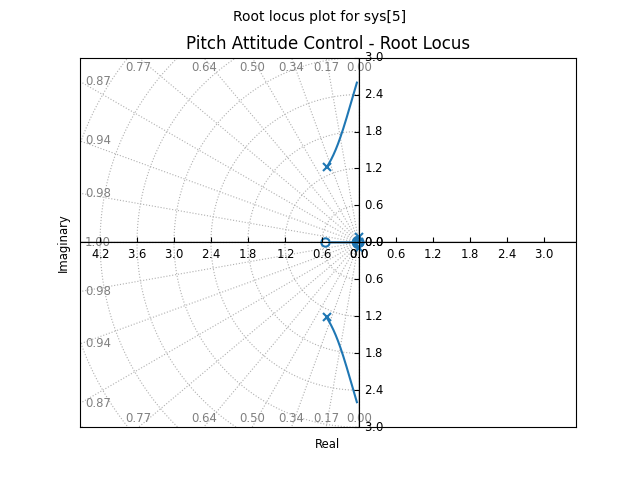

In [5]:
plt.figure()
ct.root_locus(sys1_tf,kvect=np.linspace(0,5,500), xlim=[-2, 1], ylim=[-3, 3])
plt.title('Pitch Attitude Control - Root Locus')
plt.show()

In [6]:
k_theta = 4.0
acl = sys1.A - sys1.B @ np.array([[k_theta, 0]]) @ sys1.C
sys2 = ct.ss(acl, sys1.B, sys1.C, sys1.D)
ct.ss2tf(sys2[1,0])

TransferFunction(
array([-3.01980663e-14,  1.13339550e+01,  6.52663039e+00,  1.21072582e-01,
        1.95230513e-05,  2.71050543e-20]),
array([1.00000000e+00, 1.10518377e+01, 1.22878907e+01, 6.30484474e+01,
       2.62956565e+01, 6.26905205e-01, 1.04393006e-04]),
name='sys[6]$indexed$converted', outputs=1, inputs=1)

C:\Users\jehen\AppData\Local\Temp\ipykernel_19008\932210018.py:3: FutureWarning: keyword 'kvect' is deprecated; use 'gains'
  ct.root_locus(sys2_tf,kvect=np.linspace(0,10,500), xlim=[-12, 0], ylim=[-6, 6])
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


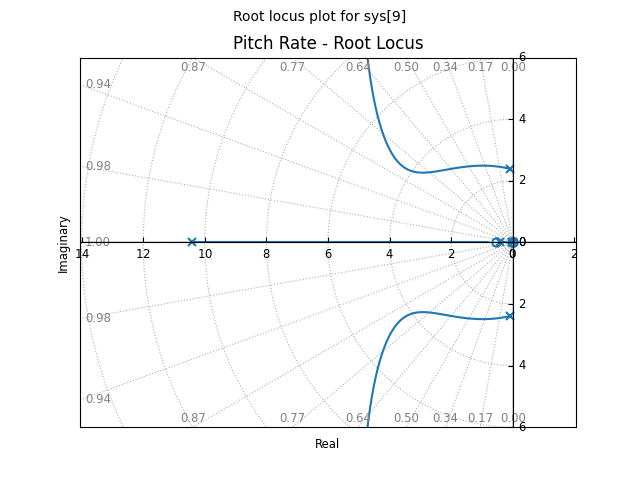

In [7]:
sys2_tf = ct.ss2tf(ct.ss(sys2.A, sys2.B, sys2.C[[1]], 0))
plt.figure()
ct.root_locus(sys2_tf,kvect=np.linspace(0,10,500), xlim=[-12, 0], ylim=[-6, 6])
plt.title('Pitch Rate - Root Locus')
plt.show()

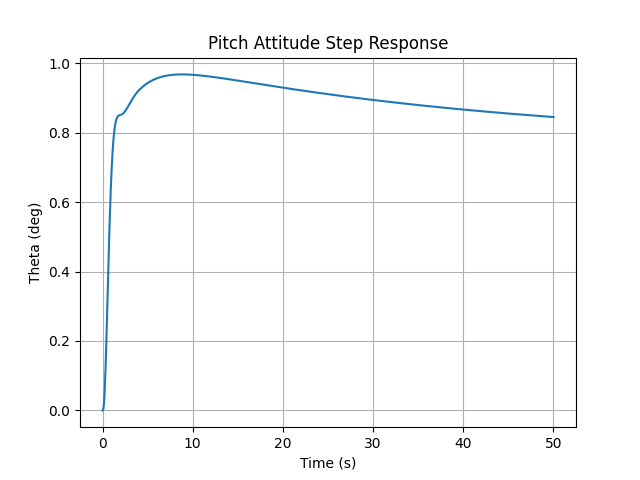

In [8]:
k_q = 2.5
acl = sys1.A - sys1.B @ np.array([[0, k_q]]) @ sys1.C
sys_theta = ct.ss(acl, sys1.B, sys1.C[[0]], sys1.D[[0]])
acl2 = sys_theta.A - sys_theta.B @ np.array([[k_theta]]) @ sys_theta.C
sys_final = ct.ss(acl2, sys_theta.B * k_theta, sys_theta.C, sys_theta.D)
plt.figure()
t, y = ct.step_response(sys_final, T=np.linspace(0,50,1000))
plt.plot(t, y.T)
plt.title('Pitch Attitude Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Theta (deg)')
plt.grid()
plt.show()

In [9]:
print(f"DC Gain: {ct.dcgain(sys_final[0,0]):.2f}")

DC Gain: 0.75


## 4.6-3

In [10]:
k_q = 2.5
k_theta = 3
acl = sys1.A - sys1.B @ np.array([[0, k_q]]) @ sys1.C
sys_theta = ct.ss(acl, sys1.B, sys1.C[[0]], sys1.D[[0]])
acl2 = sys_theta.A - sys_theta.B @ np.array([[k_theta]]) @ sys_theta.C
sys_thetac2theta = ct.ss(acl2, sys_theta.B * k_theta, sys_theta.C, sys_theta.D)

In [11]:
C_h = np.zeros([1,len(sys_thetac2theta.A)])
C_h[0,len(sys_thetac2theta.A)-1] = 1

sys_thetac2h = ct.ss(acl2, sys_thetac2theta.B, C_h, 0)

zeros = ct.zeros(sys_thetac2h)
poles = ct.poles(sys_thetac2h)

print("Closed Loop Zeros:", zeros)
print("Closed Loop Poles:", poles)

Closed Loop Zeros: [-9.76035790e+12+0.j -2.23358273e-03+0.j]
Closed Loop Poles: [-6.16971503e+00+0.j         -2.26058555e+00+1.93650432j
 -2.26058555e+00-1.93650432j -3.33194739e-01+0.j
 -2.75879105e-02+0.j         -1.68897682e-04+0.j        ]


C:\Users\jehen\AppData\Local\Temp\ipykernel_19008\2683006897.py:2: FutureWarning: keyword 'kvect' is deprecated; use 'gains'
  ct.root_locus(sys_thetac2h,kvect=np.logspace(-4,2,500), xlim=[-2, .2], ylim=[-2, 2])
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


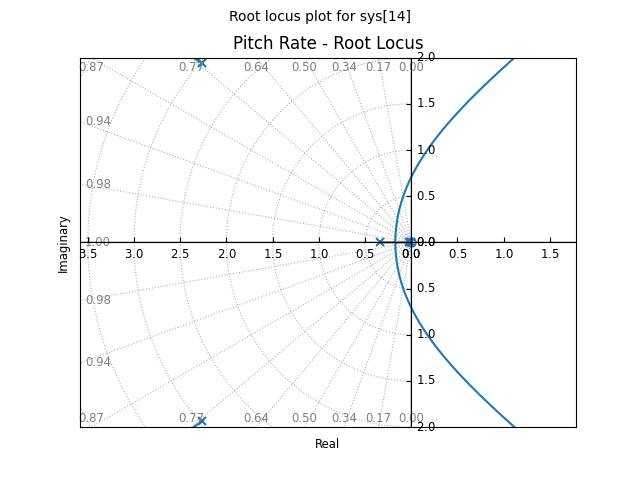

In [12]:
plt.figure()
ct.root_locus(sys_thetac2h,kvect=np.logspace(-4,2,500), xlim=[-2, .2], ylim=[-2, 2])
plt.title('Pitch Rate - Root Locus')
plt.show()

In [13]:
G_lead = ct.ss(-2.4,2.4,(0.3-2.4)/2.4,1)
ct.ss2tf(G_lead)

TransferFunction(
array([1. , 0.3]),
array([1. , 2.4]),
outputs=1, inputs=1)

C:\Users\jehen\AppData\Local\Temp\ipykernel_19008\2918680471.py:3: FutureWarning: keyword 'kvect' is deprecated; use 'gains'
  ct.root_locus(sys_hc2h_ol,kvect=np.logspace(-4,2,500), xlim=[-2, .2], ylim=[-2, 2])
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


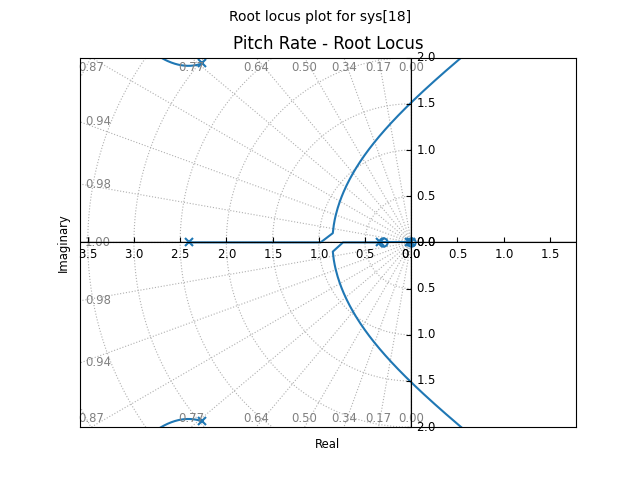

In [14]:
sys_hc2h_ol = ct.series(G_lead, sys_thetac2h)
plt.figure()
ct.root_locus(sys_hc2h_ol,kvect=np.logspace(-4,2,500), xlim=[-2, .2], ylim=[-2, 2])
plt.title('Pitch Rate - Root Locus')
plt.show()

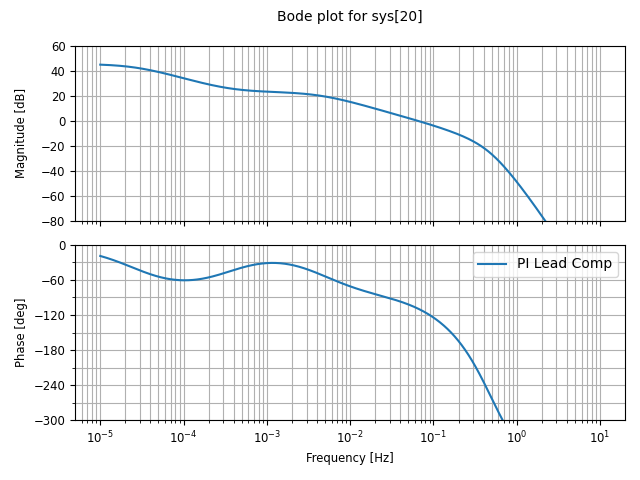

In [15]:
K_lead = 0.333

plt.figure()
ct.bode_plot(K_lead*sys_hc2h_ol, Hz=True, omega=np.logspace(-5,1,1000)*(2*3.1416), dB=True,)
plt.subplot(2,1,1)
yax1 = plt.yticks(range(-80,80,20))
plt.ylim([-80,60])
plt.subplot(2,1,2)
yax2 = plt.yticks(range(-300,60,60))
plt.ylim([-300,0])
lg = plt.legend(['PI Lead Comp','No Kp zero'])

In [16]:
G_lag = ct.ss(-0.01,0.01,4,1)
ct.ss2tf(G_lag)

TransferFunction(
array([1.  , 0.05]),
array([1.  , 0.01]),
outputs=1, inputs=1)

C:\Users\jehen\AppData\Local\Temp\ipykernel_19008\600647395.py:4: FutureWarning: keyword 'kvect' is deprecated; use 'gains'
  ct.root_locus(sys_hc2h_lag_ol,kvect=np.logspace(-4,2,500), xlim=[-2, .2], ylim=[-2, 2])
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


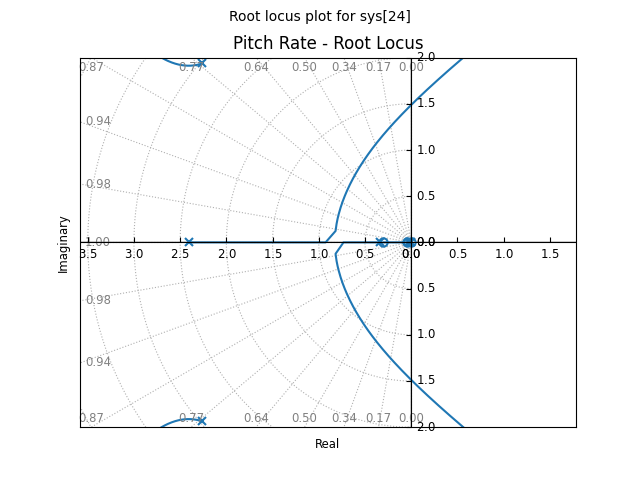

In [17]:
sys_hc2h_lag_ol = ct.series(G_lag, sys_hc2h_ol)

plt.figure()
ct.root_locus(sys_hc2h_lag_ol,kvect=np.logspace(-4,2,500), xlim=[-2, .2], ylim=[-2, 2])
plt.title('Pitch Rate - Root Locus')
plt.show()

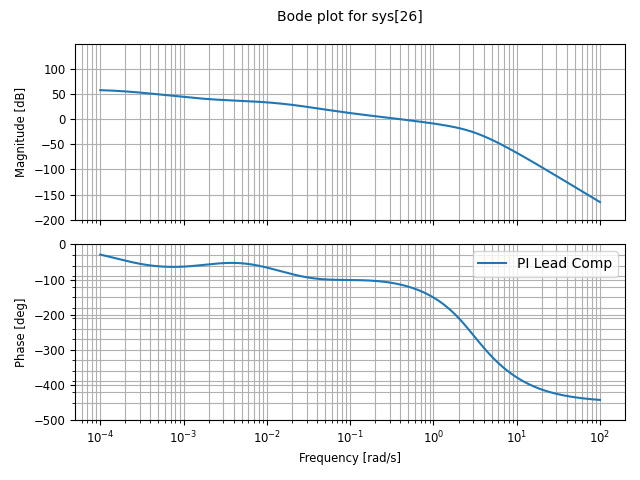

In [18]:
K_lead_lag = 0.333

plt.figure()
ct.bode_plot(K_lead_lag*sys_hc2h_lag_ol, omega=np.logspace(-4,2,1000), dB=True,)
plt.subplot(2,1,1)
yax1 = plt.yticks(range(-200,150,50))
plt.ylim([-200,150])
plt.subplot(2,1,2)
yax2 = plt.yticks(range(-500,100,100))
plt.ylim([-500,0])
lg = plt.legend(['PI Lead Comp','No Kp zero'])

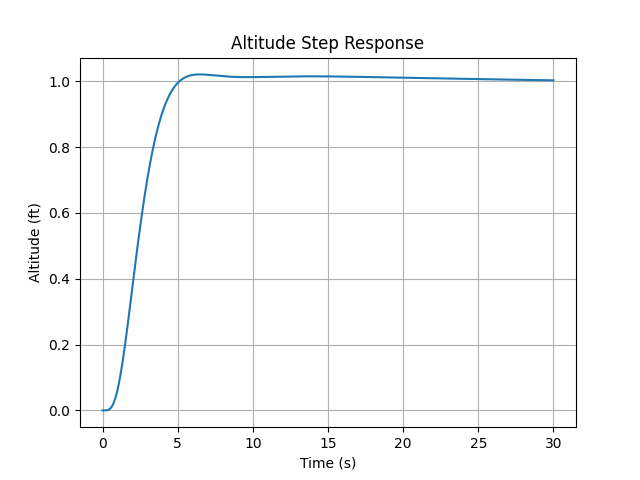

In [19]:
acl_sys_hc2h_lag = sys_hc2h_lag_ol.A - sys_hc2h_lag_ol.B @ np.array([[K_lead_lag]]) @ sys_hc2h_lag_ol.C
sys_hc2h_lag_cl = ct.ss(acl_sys_hc2h_lag, sys_hc2h_lag_ol.B * K_lead_lag, sys_hc2h_lag_ol.C, 0)
plt.figure()
t, y = ct.step_response(sys_hc2h_lag_cl, T=np.linspace(0,30,1000))
plt.plot(t, y.T)
plt.title('Altitude Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (ft)')
plt.grid()
plt.show()

In [20]:
zeros = ct.zeros(sys_hc2h_lag_cl)
poles = ct.poles(sys_hc2h_lag_cl)

print("Closed Loop Zeros:", zeros)
print("Closed Loop Poles:", poles)

Closed Loop Zeros: [-5.00000000e-02+0.j -3.00000000e-01+0.j -2.23358273e-03+0.j
 -9.74100789e+12+0.j]
Closed Loop Poles: [-6.28522393e+00+0.j         -2.75332062e+00+2.03243809j
 -2.75332062e+00-2.03243809j -6.73800674e-01+0.60357355j
 -6.73800674e-01-0.60357355j -2.67344111e-01+0.j
 -5.28153644e-02+0.j         -2.21166954e-03+0.j        ]


## Try with PI Controller Instead of Lag

#### Choose zero placement

C:\Users\jehen\AppData\Local\Temp\ipykernel_19008\2965145625.py:6: FutureWarning: keyword 'kvect' is deprecated; use 'gains'
  ct.root_locus(sys_hc2h_pi_ol,kvect=np.logspace(-4,2,500), xlim=[-2, .2], ylim=[-2, 2])
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


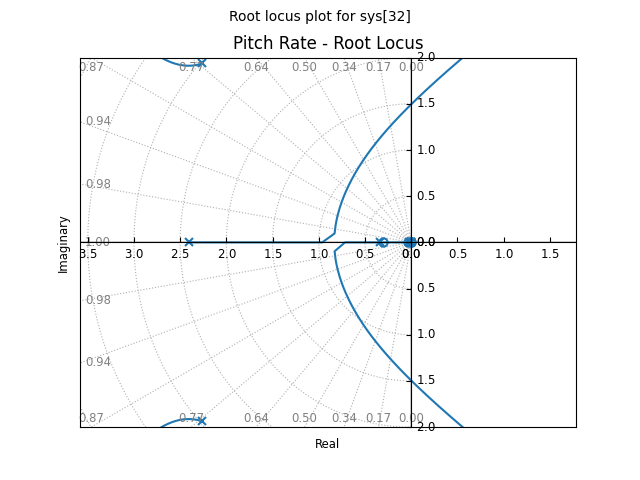

In [21]:
G_pi_zero = 0.03
G_pi = ct.ss(0,G_pi_zero,1,1)

sys_hc2h_pi_ol = ct.series(G_pi, ct.ss(0,0,0,K_lead_lag), sys_hc2h_ol)
plt.figure()
ct.root_locus(sys_hc2h_pi_ol,kvect=np.logspace(-4,2,500), xlim=[-2, .2], ylim=[-2, 2])
plt.title('Pitch Rate - Root Locus')
plt.show()

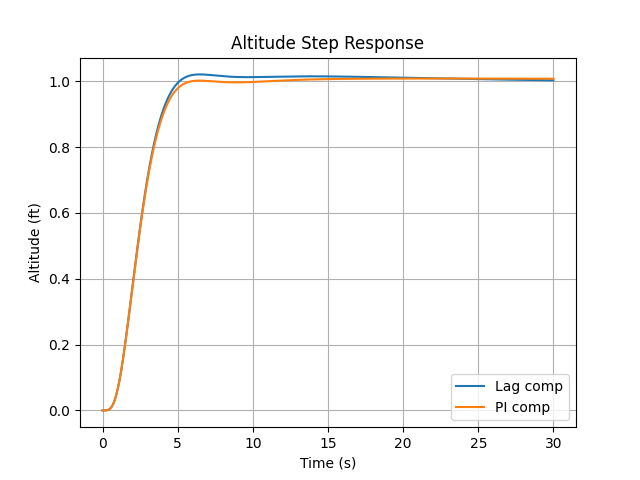

In [22]:
acl_hc2h_pi = sys_hc2h_pi_ol.A - sys_hc2h_pi_ol.B @ np.array([[1]]) @ sys_hc2h_pi_ol.C
sys_hc2h_pi = ct.ss(acl_hc2h_pi, sys_hc2h_pi_ol.B, sys_hc2h_pi_ol.C, 0)

plt.figure()
t, y = ct.step_response(sys_hc2h_lag_cl, T=np.linspace(0,30,1000))
plt.plot(t, y.T)
t, y = ct.step_response(sys_hc2h_pi, T=np.linspace(0,30,1000))
plt.plot(t, y.T)
plt.title('Altitude Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (ft)')
plt.legend(['Lag comp','PI comp'])
plt.grid()
plt.show()